## Lab 7.01 Neural Network Binary Classification
_By Jeff Hale_

This lab uses a small [dataset](https://archive.ics.uci.edu/ml/datasets/heart+Disease) provided by the Cleveland Clinic Foundation for Heart Disease. The goal is to predict whether a patient has heart disease (the *target* column).

We suggest running this lab in [Google Colab](https://colab.research.google.com/). 

Go *File*->*Upload notebook* to upload this notebook to colab.

If you are working in Colab and want to see if you can get a speed boost, set your runtime to *GPU* or *TPU* by going to *Runtime*->*Change runtime type* in the menu above. 

The processor type won't make a big difference with this small dataset and small networks, but it's good to know how to change the processor.

### Get data and then use pandas to load it into a DataFrame

#### Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split


Retrieve the csv file containing the heart dataset that ships with TensorFlow.

In [3]:
csv_file = tf.keras.utils.get_file('heart.csv', 'https://storage.googleapis.com/download.tensorflow.org/data/heart.csv')

24576/13273 [=======================================================] - 0s 0us/step


#### Load the csv file using pandas.

In [4]:
heart = pd.read_csv(csv_file)
heart.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


#### Inspect

In [5]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    object 
 13  target    303 non-null    int64  
dtypes: float64(1), int64(12), object(1)
memory usage: 33.3+ KB


In [6]:
heart.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [7]:
heart['target'].value_counts()

0    220
1     83
Name: target, dtype: int64

#### Check the value counts of the column that's an object

In [8]:
heart['thal'].value_counts()

normal        168
reversible    115
fixed          18
1               1
2               1
Name: thal, dtype: int64

In [9]:
heart[(heart['thal'] == '1') | (heart['thal'] == '2')]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
247,59,1,0,164,176,1,0,90,0,1.0,1,2,1,0
252,57,0,1,130,236,0,0,174,0,0.0,1,1,2,0


In [10]:
heart = heart[(heart['thal'] != '1') & (heart['thal'] != '2')]

In [11]:
heart['thal'].value_counts()

normal        168
reversible    115
fixed          18
Name: thal, dtype: int64

You could load data into a format for TensorFlow using `tf.data.Dataset`, but these are unwieldly - it's a serious pain to create a validation dataset from a TF dataset. You used to have to make your data into NumPy arrays for TensorFlow. Now you can just keep them as pandas DataFrames!

#### Set up X and y

In [12]:
X = heart.drop(columns='target')
y = heart['target']

In [13]:
X.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal


In [14]:
y.head()

0    0
1    1
2    0
3    0
4    0
Name: target, dtype: int64

#### Train-test split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=13)

Convert `thal` column to numeric

#### Use scikit-learn to one-hot encode  

In [16]:
X_train.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal         object
dtype: object

In [17]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_selector, make_column_transformer

ct = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), make_column_selector(dtype_include=object)),
    remainder='passthrough',
    verbose_feature_names_out=False,
)

In [18]:
X_train_t = ct.fit_transform(X_train)
X_test_t = ct.transform(X_test)

In [19]:
ss = StandardScaler()
X_train_t_s = ss.fit_transform(X_train_t)
X_test_t_s = ss.fit_transform(X_test_t)

In [20]:
X_train_df = pd.DataFrame(X_train_t_s, columns=ct.get_feature_names_out())
X_train_df.head(2)

,thal_fixed,thal_normal,thal_reversible,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca
0,-0.276686,0.935414,-0.808957,0.432765,-1.519481,-2.028484,1.106670,0.692117,2.370158,1.057315,0.565762,-0.700047,-0.057886,-0.955320,-0.715102
1,3.614208,-1.069045,-0.808957,-1.465546,0.658119,-1.071652,0.238467,-0.803813,-0.421913,-0.967331,-0.730976,-0.700047,-0.962357,0.710936,-0.715102


In [21]:
X_test_df = pd.DataFrame(X_test_t_s, columns=ct.get_feature_names_out())
X_test_df.head(2)

,thal_fixed,thal_normal,thal_reversible,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca
0,-0.164399,-1.309307,1.38675,0.340978,0.785507,0.967352,0.318706,-1.515187,-0.389249,-1.149594,0.518409,1.428286,-0.794535,-0.996815,0.234181
1,-0.164399,0.763763,-0.72111,0.780203,-1.273063,-0.163706,0.050173,0.057099,-0.389249,0.906150,0.968684,-0.700140,-0.794535,-0.996815,-0.754584


#### Set the TensorFlow random seed

In [22]:
# With help from https://www.tensorflow.org/api_docs/python/tf/keras/utils/set_random_seed

tf.keras.utils.set_random_seed(
    1331
)

## Create and train a model

#### Create model structure

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [24]:
model = Sequential()
model.add(Dense(35, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

#### Compile

In [25]:
# Using help from the docs to get metrics right
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

#### Make an EarlyStopping callback

In [26]:
# With help from tensorflow documentation
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

#### Fit the model

In [27]:
history = model.fit(
    X_train_df,
    y_train,
    validation_data=(X_test_df, y_test),
    epochs=100,
    callbacks=callback,
    verbose=0
)

#### Plot model performance on the validation data (accuracy, recall, and precision)

In [28]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'recall', 'precision', 'val_loss', 'val_accuracy', 'val_recall', 'val_precision'])

''

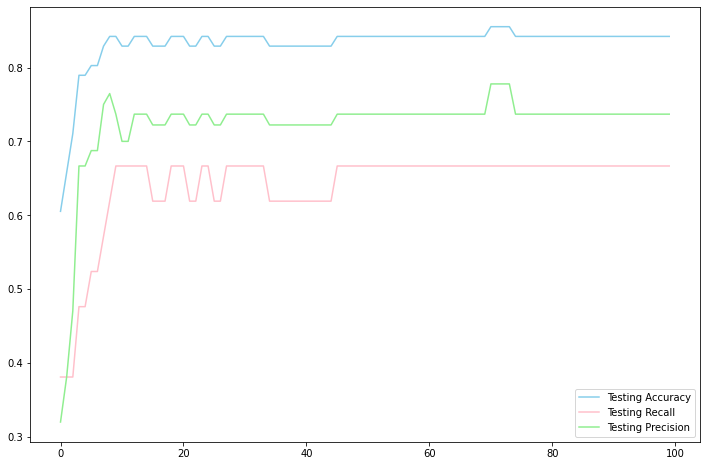

In [29]:
# With help from regularization lesson
# Can substitute hard coded dict keys for reference to history.history.keys()
train_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']
train_recall = history.history['recall']
test_recall = history.history['val_recall']
train_precision = history.history['precision']
test_precision = history.history['val_precision']

plt.figure(figsize=(12, 8))
# plt.plot(train_accuracy, label='Training Accuracy', color='navy')
plt.plot(test_accuracy, label='Testing Accuracy', color='skyblue')
# plt.plot(train_recall, label='Training Recall', color='darkred')
plt.plot(test_recall, label='Testing Recall', color='pink')
# plt.plot(train_precision, label='Training Precision', color='green')
plt.plot(test_precision, label='Testing Precision', color='lightgreen')
plt.legend()
;

#### Save model

In [30]:
model.save('./first_model')

INFO:tensorflow:Assets written to: ./first_model/assets


#### Load model

In [31]:
reloaded_model = tf.keras.models.load_model('./first_model')

#### Evaluate on test set 

In [32]:
reloaded_model.evaluate(X_test_df, y_test)

3/3 [==============================] - 0s 7ms/step - loss: 0.3359 - accuracy: 0.8421 - recall: 0.6667 - precision: 0.7368


[0.3358832895755768,
 0.8421052694320679,
 0.6666666865348816,
 0.7368420958518982]

#### X_test predictions

In [33]:
y_preds = reloaded_model.predict(X_test_df)
y_preds[:5]

array([[0.25420138],
       [0.0019516 ],
       [0.5772854 ],
       [0.07616525],
       [0.7671432 ]], dtype=float32)

#### What do those look like?

''

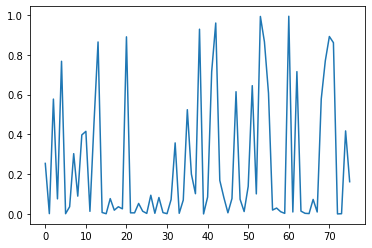

In [34]:
plt.plot(y_preds)
;

#### How is the model performing? 
Let's look at the confusion matrix using TF.

In [35]:
# Using the docs
tf_confusion = tf.compat.v1.confusion_matrix(
    labels=y_test,
    predictions=reloaded_model.predict(X_test_df),
    
)

In [36]:
tf_confusion

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[55,  0],
       [21,  0]], dtype=int32)>

Or just use sklearn's confusion matrix. 

In [37]:
from sklearn.metrics import ConfusionMatrixDisplay

''

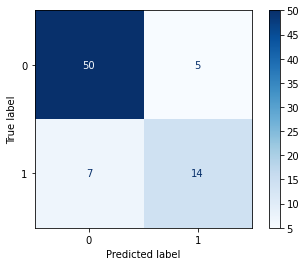

In [38]:
# With help from https://stackoverflow.com/questions/56458526/get-confusion-matrix-from-a-keras-model/56458627
# np.rint
ConfusionMatrixDisplay.from_predictions(y_test, np.rint(y_preds), cmap='Blues')
;

#### Evaluate with other metrics

Recall and precision metrics included in the model, will rerun below.

In [39]:
reloaded_model.evaluate(X_test_df, y_test)

3/3 [==============================] - 0s 7ms/step - loss: 0.3359 - accuracy: 0.8421 - recall: 0.6667 - precision: 0.7368


[0.3358832895755768,
 0.8421052694320679,
 0.6666666865348816,
 0.7368420958518982]

### Make a null model

In [40]:
from sklearn.dummy import DummyClassifier

dc = DummyClassifier()
dc.fit(X_train_df, y_train)
dc.score(X_test_df, y_test)

0.7236842105263158

## Can you make a better model?

Change the model architecture and see if you can make a better model. Add nodes, dense layers, and dropout layers.

## Grid Search over NN hyperparameters

Following this tutorial: https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

In [41]:
# Got error KerasClassifier was deprecated, switched to scikeras
!pip install scikeras
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.10.1
    Uninstalling importlib-metadata-4.10.1:
      Successfully uninstalled importlib-metadata-4.10.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
markdown 3.3.6 requires importlib-metadata>=4.4; python_version < "3.10", but you have importlib-metadata 3.10.1 which is incompatible.


### Gird Search for batch and epochs

In [42]:
# Got input shape error in grid search. Using this from lesson with Chuck given: "Model <keras.engine.sequential.Sequential object at 0x7fdf22f98410> cannot be saved because the input shapes have not been set. Usually, input shapes are automatically determined when calling `.fit()` or `.predict()`. To manually set the shapes, call `model.build(input_shape)"
n_input = X_train_df.shape[1]

In [43]:
# Create model function. Required by KerasClassifier
def create_model():
  # First try let's replicate my previous model
  model = Sequential()
  model.add(Dense(35, input_dim=n_input, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  # Model compile
  model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
  )
  return model

# Create/Instantiate? model. Verbose=0 keeps output clean
model = KerasClassifier(model=create_model, verbose=0)

# Define grid search parameters. I'm using the same from my tutorial to start it off.
params= {
    'batch_size': [10, 20, 30, 40, 60, 80, 100],
    'epochs': [10, 50, 100]
}
# Grid Search
gs = GridSearchCV(
    estimator=model,
    param_grid=params,
    n_jobs=-1,
    cv=3,
    scoring='f1'
)
gs_result = gs.fit(X_train_df, y_train)

# Result summary
print(f"Best score: {gs_result.best_score_}. Used these parameters: {gs_result.best_params_}")

# This part copied from machine learning mastery prints out all results to check where improvements can be made
means = gs_result.cv_results_['mean_test_score']
stds = gs_result.cv_results_['std_test_score']
params = gs_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best score: 0.7004830917874396. Used these parameters: {'batch_size': 100, 'epochs': 50}
0.699291 (0.065602) with: {'batch_size': 10, 'epochs': 10}
0.644986 (0.015330) with: {'batch_size': 10, 'epochs': 50}
0.640693 (0.019680) with: {'batch_size': 10, 'epochs': 100}
0.621328 (0.079274) with: {'batch_size': 20, 'epochs': 10}
0.697909 (0.052157) with: {'batch_size': 20, 'epochs': 50}
0.666919 (0.012969) with: {'batch_size': 20, 'epochs': 100}
0.619048 (0.067344) with: {'batch_size': 30, 'epochs': 10}
0.698413 (0.022448) with: {'batch_size': 30, 'epochs': 50}
0.654623 (0.028427) with: {'batch_size': 30, 'epochs': 100}
0.637037 (0.041903) with: {'batch_size': 40, 'epochs': 10}
0.698450 (0.001096) with: {'batch_size': 40, 'epochs': 50}
0.666507 (0.089090) with: {'batch_size': 40, 'epochs': 100}
0.454640 (0.169272) with: {'batch_size': 60, 'epochs': 10}
0.691879 (0.050289) with: {'batch_size': 60, 'epochs': 50}
0.640458 (0.015139) with: {'batch_size': 60, 'epochs': 100}
0.462091 (0.209944) w

Best accuracy score: 0.8266666666666667. Used these parameters: {'batch_size': 10, 'epochs': 10}

Took a few minutes to run.

Rerun with GridSearchCV scoring='f1'. Best F1: 0.7806637806637807. Used these parameters: {'batch_size': 10, 'epochs': 10}

### Grid Search for Dropout rate

Let's try dropout regularization tuning from the tutorial. It's the same code as before but the model function is changed to incorporate dropout inputs into it and be able to grid search over them.

In [ ]:
# Create model function. Required by KerasClassifier.
# Dropout rate and weight constraint included as default variables for grid search
# Import for weight_constraint
from keras.constraints import maxnorm
from tensorflow.keras.layers import Dropout

def create_model(dropout_rate=0.0, weight_constraint=0):
  # First try let's replicate my previous model
  model = Sequential()
  # Adding kernel initializer and kernel constraint here per tutorial
  model.add(Dense(35, input_dim=n_input, kernel_initializer='uniform', activation='relu', kernel_constraint=maxnorm(weight_constraint)))
  # Add the dropout layer
  model.add(Dropout(dropout_rate))
  model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
  # Model compile
  model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
  )
  return model

# Create/Instantiate? model. Verbose=0 keeps output clean. Use epochs=100 from my first model.
# Batch_size from previous grid search
model = KerasClassifier(model=create_model, verbose=0, epochs=100, batch_size=10, dropout_rate=0.0, weight_constraint=0)

# Define grid search parameters. I'm using the same from my tutorial to start it off.
params= {
    'weight_constraint': [1, 2, 3, 4, 5],
    'dropout_rate': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
}
# Grid Search
gs2 = GridSearchCV(
    estimator=model,
    param_grid=params,
    n_jobs=-1,
    cv=3,
    scoring='f1'
)
gs_result2 = gs2.fit(X_train_df, y_train)

# Result summary
print(f"Best score: {gs_result2.best_score_}. Used these parameters: {gs_result2.best_params_}")

# This part copied from machine learning mastery prints out all results to check where improvements can be made
means = gs_result2.cv_results_['mean_test_score']
stds = gs_result2.cv_results_['std_test_score']
params = gs_result2.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best score: 0.6875901875901876. Used these parameters: {'dropout_rate': 0.9, 'weight_constraint': 2}
0.634921 (0.022448) with: {'dropout_rate': 0.0, 'weight_constraint': 1}
0.651398 (0.012372) with: {'dropout_rate': 0.0, 'weight_constraint': 2}
0.619299 (0.046241) with: {'dropout_rate': 0.0, 'weight_constraint': 3}
0.635608 (0.021908) with: {'dropout_rate': 0.0, 'weight_constraint': 4}
0.626599 (0.031082) with: {'dropout_rate': 0.0, 'weight_constraint': 5}
0.612698 (0.039904) with: {'dropout_rate': 0.1, 'weight_constraint': 1}
0.617749 (0.046781) with: {'dropout_rate': 0.1, 'weight_constraint': 2}
0.634343 (0.027254) with: {'dropout_rate': 0.1, 'weight_constraint': 3}
0.644682 (0.026308) with: {'dropout_rate': 0.1, 'weight_constraint': 4}
0.617827 (0.038919) with: {'dropout_rate': 0.1, 'weight_constraint': 5}
0.620742 (0.032954) with: {'dropout_rate': 0.2, 'weight_constraint': 1}
0.619364 (0.044219) with: {'dropout_rate': 0.2, 'weight_constraint': 2}
0.641012 (0.018783) with: {'dropout

Best accuracy score: 0.831111111111111. Used these parameters: {'dropout_rate': 0.9, 'weight_constraint': 3}

Around 15 minutes to run!

Rerun with GridSearchCV scoring=F1. Best F1: 69.74%. Used these parameters: {'dropout_rate': 0.9, 'weight_constraint': 1}

### Save your best model. 


In [44]:
gs_result.best_estimator_ #.build_fn

KerasClassifier(
	model=<function create_model at 0x7fd0301ba440>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=100
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=50
	class_weight=None
)

In [46]:
gs_result.best_estimator_.model_.save('./best_gs_model/')

INFO:tensorflow:Assets written to: ./best_gs_model/assets


### Compare with other algorithms
Compare your best neural net model to scikit-learn's LogisticRegression, SVM, and GradientBoostingClassifier. Hyperparameter search for good options.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

#### Logistic Regression

In [ ]:
logreg = LogisticRegression(max_iter=10_000)

In [ ]:
logreg.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [ ]:
params = {
    'C': [.01, .1, 1, 10, 100],
    'n_jobs': [-1]
}

gs_logreg = GridSearchCV(
    logreg,
    params,
    n_jobs=-1,
    scoring='f1'
)

logreg_results = gs_logreg.fit(X_train_df, y_train)

print(f"Best score: {logreg_results.best_score_}. Used these parameters: {logreg_results.best_params_}")

means = logreg_results.cv_results_['mean_test_score']
stds = logreg_results.cv_results_['std_test_score']
params = logreg_results.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"{mean} ({stdev}) with: {param}")

Best score: 0.7195844155844154. Used these parameters: {'C': 10, 'n_jobs': -1}
0.47581699346405226 (0.07592959859585677) with: {'C': 0.01, 'n_jobs': -1}
0.7185550745550745 (0.08413149906301527) with: {'C': 0.1, 'n_jobs': -1}
0.7140459540459541 (0.05304752121397003) with: {'C': 1, 'n_jobs': -1}
0.7195844155844154 (0.05192248721602161) with: {'C': 10, 'n_jobs': -1}
0.7195844155844154 (0.05192248721602161) with: {'C': 100, 'n_jobs': -1}


Best score: 0.7195844155844154. Used these parameters: {'C': 10, 'n_jobs': -1}

#### Gradient Boosting Classifier

In [ ]:
gb = GradientBoostingClassifier()

In [ ]:
gb.get_params().keys()

dict_keys(['ccp_alpha', 'criterion', 'init', 'learning_rate', 'loss', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_iter_no_change', 'random_state', 'subsample', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

In [ ]:
gb_params = {
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.5],
    'n_estimators': [50, 100, 150, 200]
}

In [ ]:
gs_boost = GridSearchCV(
    gb,
    gb_params,
    scoring='f1',
    n_jobs=-1
)

In [ ]:
boost_results = gs_boost.fit(X_train_df, y_train)

print(f"Best score: {boost_results.best_score_}. Used these parameters: {boost_results.best_params_}")

means = boost_results.cv_results_['mean_test_score']
stds = boost_results.cv_results_['std_test_score']
params = boost_results.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"{mean} ({stdev}) with: {param}")

Best score: 0.5894845017682546. Used these parameters: {'learning_rate': 0.01, 'n_estimators': 150}
0.23630252100840332 (0.08520888696518437) with: {'learning_rate': 0.01, 'n_estimators': 50}
0.5123742690058479 (0.06843000491241284) with: {'learning_rate': 0.01, 'n_estimators': 100}
0.5894845017682546 (0.09099563654531857) with: {'learning_rate': 0.01, 'n_estimators': 150}
0.576711462450593 (0.08013801153049693) with: {'learning_rate': 0.01, 'n_estimators': 200}
0.5494387351778657 (0.07838081756986745) with: {'learning_rate': 0.05, 'n_estimators': 50}
0.5674855579203406 (0.08131572738134041) with: {'learning_rate': 0.05, 'n_estimators': 100}
0.5599562916954223 (0.07791415611983385) with: {'learning_rate': 0.05, 'n_estimators': 150}
0.5532896250287556 (0.06619021119155444) with: {'learning_rate': 0.05, 'n_estimators': 200}
0.567077125772778 (0.06066783695153997) with: {'learning_rate': 0.1, 'n_estimators': 50}
0.5762145262145262 (0.0709701662195739) with: {'learning_rate': 0.1, 'n_estim

#### SVM

In [ ]:
svc = SVC()

In [ ]:
svc.get_params().keys()

dict_keys(['C', 'break_ties', 'cache_size', 'class_weight', 'coef0', 'decision_function_shape', 'degree', 'gamma', 'kernel', 'max_iter', 'probability', 'random_state', 'shrinking', 'tol', 'verbose'])

In [ ]:
# Using the np.linspace from optional lesson for C grid search
svc_params = {
    'C': np.linspace(0.0001, 2, 10),
    'kernel': ['rbf', 'poly', 'sigmoid']
}

In [ ]:
gs_svc = GridSearchCV(
    svc,
    svc_params,
    scoring='f1',
    n_jobs=-1
)

In [ ]:
svc_results = gs_svc.fit(X_train_df, y_train)

print(f"Best score: {svc_results.best_score_}. Used these parameters: {svc_results.best_params_}")

means = svc_results.cv_results_['mean_test_score']
stds = svc_results.cv_results_['std_test_score']
params = svc_results.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"{mean} ({stdev}) with: {param}")

Best score: 0.755320910973085. Used these parameters: {'C': 1.3333666666666666, 'kernel': 'sigmoid'}
0.0 (0.0) with: {'C': 0.0001, 'kernel': 'rbf'}
0.0 (0.0) with: {'C': 0.0001, 'kernel': 'poly'}
0.0 (0.0) with: {'C': 0.0001, 'kernel': 'sigmoid'}
0.3538001867413632 (0.14618672121795792) with: {'C': 0.2223111111111111, 'kernel': 'rbf'}
0.3647058823529412 (0.10580062205061735) with: {'C': 0.2223111111111111, 'kernel': 'poly'}
0.7364098864098864 (0.05238479507424614) with: {'C': 0.2223111111111111, 'kernel': 'sigmoid'}
0.5931419457735247 (0.06675817685592987) with: {'C': 0.4445222222222222, 'kernel': 'rbf'}
0.408328173374613 (0.08669385203063541) with: {'C': 0.4445222222222222, 'kernel': 'poly'}
0.7309911671980638 (0.04824192611288256) with: {'C': 0.4445222222222222, 'kernel': 'sigmoid'}
0.6309253065774805 (0.0739359451733071) with: {'C': 0.6667333333333333, 'kernel': 'rbf'}
0.46721706226350185 (0.031017909676941367) with: {'C': 0.6667333333333333, 'kernel': 'poly'}
0.7418540080609046 (0.

#### Which model performs best in terms of F1 Score?

- Logistic Regression Best F1: 71.96%
- Gradient Boosting Best F1: 58.95%
- SVC Best F1: 75.53%
- NN Best F1: 78.07%

#### What does the F1 Score mean in a few words?

With help from: https://towardsdatascience.com/the-f1-score-bec2bbc38aa6

F1 score is the harmonic mean of precision and recall. This means that it takes an average of precision and recall and accounts for difference in scores from imbalanced datasets in a single metric, where accuracy by itself could be misleading.

#### Which model would you recommend for use? Why?

Given the computational cost of NN models I would recommend using SVC given the F1 score is pretty close but the model is a lot less costly to run.


#### Download your notebook and put it in your submission folder. 🎉